# Using RomanMachine to Build a PRF Model

This tutorial notebook shows how to use `RomanMachine` to build and save a PRF model from the 
simulated images.

We start with the basic imports...

In [39]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from astropy.io import fits
from astropy.visualization import simple_norm

from roman_lcs import RomanMachine
from roman_lcs.utils import clean_blends_in_catalog, _make_A_polar

We define a few global variables to be used in the notebook. 
You'll need to change the `PATH` to match where your simulated images are stored.

For this example, we will use simulated images from `RImTimSim` in the F146 band, field 3 and the SCA 2

In [2]:
# change PATH to you local directoy with the images
PATH = "/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01"
FILTER = "F146"
FIELD = 3
SCA = 2

In [3]:
ff = sorted(
    glob(
        f"{PATH}/cutout_sample/rimtimsim_WFI_lvl02_{FILTER}_SCA{SCA:02}_field{FIELD:02}_rampfitted_exposureno_*_sim.fits"
    )
)
print(f"There are {len(ff)} frames available in {FILTER}")

There are 1 frames available in F146


Because the FFI is 4088 x 4088 pixels and is too large to fit at once, memory limitations and inversion of large matrices are untractable, we will work in smaller cutouts. 

To build the PRF model we will use 512 x 512 pixel cutouts in the center of the FFI. This tutorial uses one cutout as an example, but PRF models can be computed for multiple cutouts across the FFI. Because the current version of `RImTimSim` simulations does not change the PSF in time or across the SCA, we can compute a single average model for the entire FFI. 

We'll only use bright (F146 < 20) isolated stars to build the PRF model. Magnitude dependency for the PRF model will be implemented in future versions. 

In [21]:
cutout_size = 512 # in pixels
cutout_center = (268.47034093076417, -29.212587508331787) # in radec
cutout_origin = [1245, 1155] # in pixels
mag_limit = 20
blend_limit = 0.1 / 2  # max source distance to remove blends , in arcsec
buffer = 1  # pixel edge-buffer for catalog query

Now we read the input catalog from where we'll use the source locations and a first guess of the star flux. We filter sources inside the cutout and brighter than `mag_limit`

In [22]:
# load surce catalogs in the cutout
with sqlite3.connect(
    f"{PATH}/metadata/TRExS_dryrun_01_MASTER_input_catalog_v1.1.db"
) as conn:
    query = (
        f"F146 <= {mag_limit} and "
        f"MEAN_XCOL >= {cutout_origin[0] - buffer} and MEAN_XCOL <= {cutout_origin[0] + cutout_size + buffer} and "
        f"MEAN_YCOL >= {cutout_origin[1] - buffer} and MEAN_YCOL <= {cutout_origin[1] + cutout_size + buffer}"
    )
    sources = pd.read_sql_query(
        f"SELECT * FROM Master_input_catalog WHERE {query}", conn
    ).reset_index(drop=True)

# rename columns so Machine can read the right columns
sources = sources.rename(
    columns={
        "RA_DEG": "ra",
        "DEC_DEG": "dec",
        "MEAN_XCOL": "column",
        "MEAN_YCOL": "row",
        f"{FILTER}_flux": "flux",
        f"{FILTER}_flux_err": "flux_err",
    }
)
sources = clean_blends_in_catalog(sources, blend_limit=blend_limit, filter="F146")
sources


sicbro_id          ra        dec       column          row     F062  \
0             8  268.467077 -29.209018  1360.785954  1467.102453  19.4014   
1            12  268.476330 -29.209684  1602.799369  1586.358007  21.3367   
2           144  268.460898 -29.212403  1261.982393  1274.661532  15.2285   
3           474  268.470638 -29.206137  1402.455984  1605.408426  15.9354   
4           477  268.473847 -29.209169  1532.354374  1564.258777  18.3177   
...         ...         ...        ...          ...          ...      ...   
3253    4972973  268.472886 -29.207088  1474.220159  1611.148213  16.9844   
3254    4973080  268.479920 -29.211611  1724.099228  1583.466303  20.2687   
3255    4973102  268.475774 -29.212107  1628.672034  1506.647270  16.6448   
3256    4973121  268.465234 -29.207498  1289.797234  1484.209982  19.2689   
3257    4973137  268.468982 -29.217895  1553.945612  1234.246733  20.3488   

         F087     F106     F129     F158  ...  lowmassEB  lowRedNoise  \
0     18.1226  17.5756  17.0287  16.9018  ...          0            1   
1     19.8629  19.2150  18.5671  18.4378  ...          0            0   
2     14.9954  14.9033  14.8112  14.8074  ...          0            0   
3     15.6537  15.5669  15.4802  15.4743  ...          0            0   
4     17.7683  17.4457  17.1232  16.9539  ...          0            0   
...       ...      ...      ...      ...  ...        ...          ...   
3253  16.1297  15.8085  15.4872  15.2061  ...          0            0   
3254  19.5931  19.3609  19.1287  18.9898  ...          0            0   
3255  15.7670  15.4260  15.0851  14.7712  ...          0            0   
3256  18.5142  18.2464  17.9785  17.7629  ...          0            0   
3257  19.6230  19.3782  19.1334  18.9824  ...          0            0   

      hiRedNoise  variable      F087_flux  F087_flux_err           flux  \
0              0         1    5839.916911      76.419349   16561.004232   
1              0         1    1175.673335      34.288093    4032.799849   
2              0         0  104060.682065     322.584380  115506.564841   
3              0         0   56750.104836     238.222805   62570.073934   
4              0         0    8093.319179      89.962877   15239.357881   
...          ...       ...            ...            ...            ...   
3253           0         0   36607.213164     191.330116   74179.972527   
3254           0         0    1507.324187      38.824273    2378.847864   
3255           0         0   51126.571244     226.111856  109983.280195   
3256           0         0    4071.614648      63.809205    7181.359500   
3257           0         0    1466.380471      38.293348    2389.828127   

        flux_err      F213_flux  F213_flux_err  
0     128.689565   15063.526928     122.733561  
1      63.504329    3717.120740      60.968194  
2     339.862568   88325.614613     297.196256  
3     250.140109   48279.934046     219.726953  
4     123.447794   13024.668187     114.125668  
...          ...            ...            ...  
3253  272.360005   69862.909486     264.315927  
3254   48.773434    2064.841252      45.440524  
3255  331.637272  107104.241061     327.267843  
3256   84.742902    6493.018917      80.579271  
3257   48.885868    2102.454802      45.852533  

[3258 rows x 26 columns]

## RomanMachine

We initialize a `RomanMachine` object with the images and the source catalog above.
Because the simulations were created with a static PSF, we can compute the PRF model from a single frame.

In [23]:
mac = RomanMachine.from_file(
    ff, 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_center=cutout_center,
)
# we specify flux limit to consider contamination
# this helps get more datapoints to build the model
# in reality we should push this to lower values, but 
# that increases the chances to get an unsolvable
# system of equations
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

Creating delta arrays: 100%|██████████████████████████████████████████████████████████████| 3258/3258 [00:04<00:00, 799.71it/s]


RomanMachine (N sources, N times, N pixels): (3258, 1, 262144)

In [29]:
mac.meta

{'MISSION': 'Roman-Sim',
 'TELESCOP': 'Roman',
 'SOFTWARE': 'rimtimsim_v2.0',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 1,
 'DETECTOR': 'SCA02',
 'EXPOSURE': 54.72,
 'READMODE': 'ramp'}

We can inspect the frame we loaded and the sources in the catalog

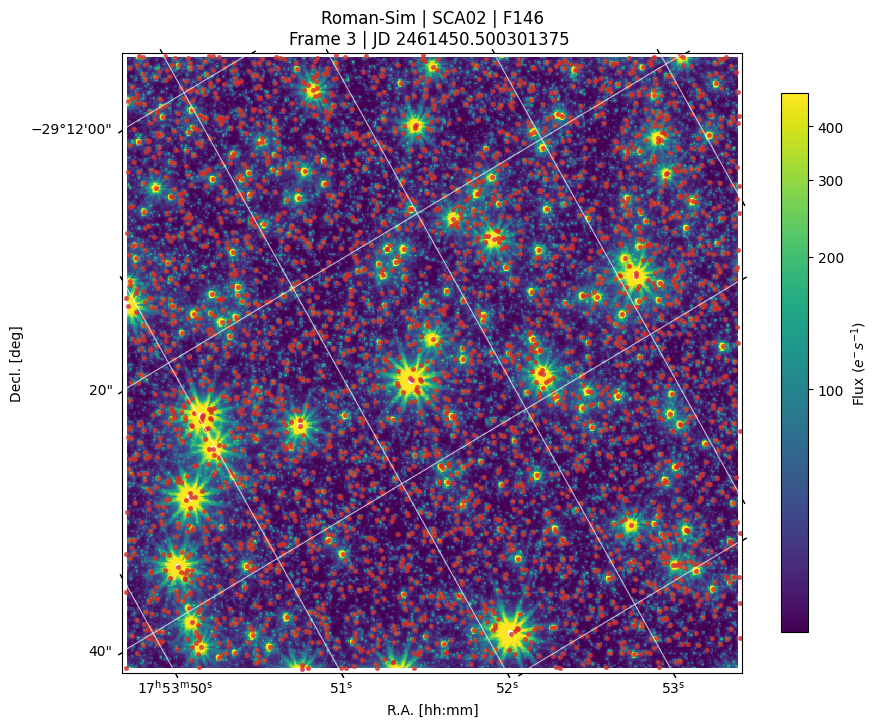

In [24]:
mac.plot_image(sources=True, frame_index=0);

We compute a pixe lmask for every source. The figures show the flux of each pixel and its distance to the postion of their source.
We fit a 1st-degree polynomial to the normalized pixel flux (in log space) and define the radius of a source when its flux goes under the background level (`source_flux_limit`).

This is a first approximation to the source mask. 

/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


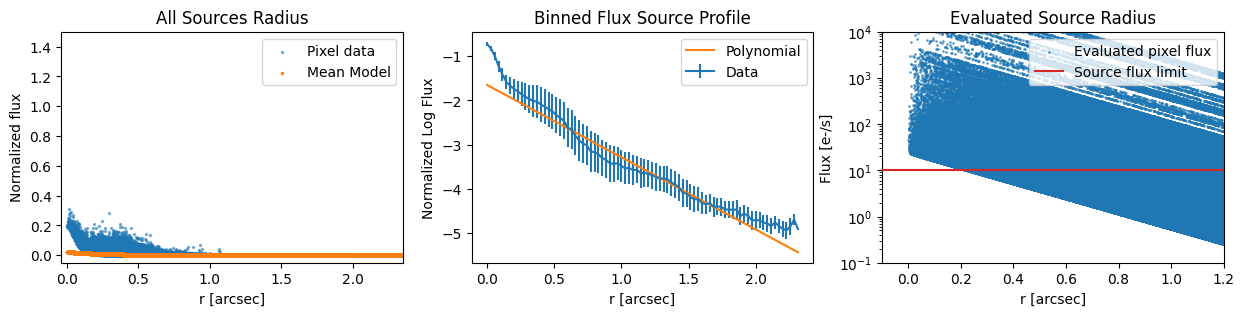

In [25]:
mac._get_source_mask(source_flux_limit=10, plot=True, reference_frame=0, iterations=2);

We can visualize a sample of sources and their first source mask

In [26]:
# we select a fixed random set of bright sources 
examples = np.random.choice(mac.sources.query("F146 > 16 and F146 < 18").index.values, size=7*7)
examples

array([ 966, 2671, 3111, 3160, 3073, 3013, 2967,   11, 3098,  480,   51,
       2852,  232, 3039,  480, 3062, 3075,  351,  603, 1626,  805, 3168,
        267, 3075,  176,   79,  939, 3126, 3088, 3039, 3067,  536,  750,
         63, 3078, 3169,  803,  614,   83, 3235,   83,   36, 2835, 3214,
         52,  505, 3247, 2766,  196])

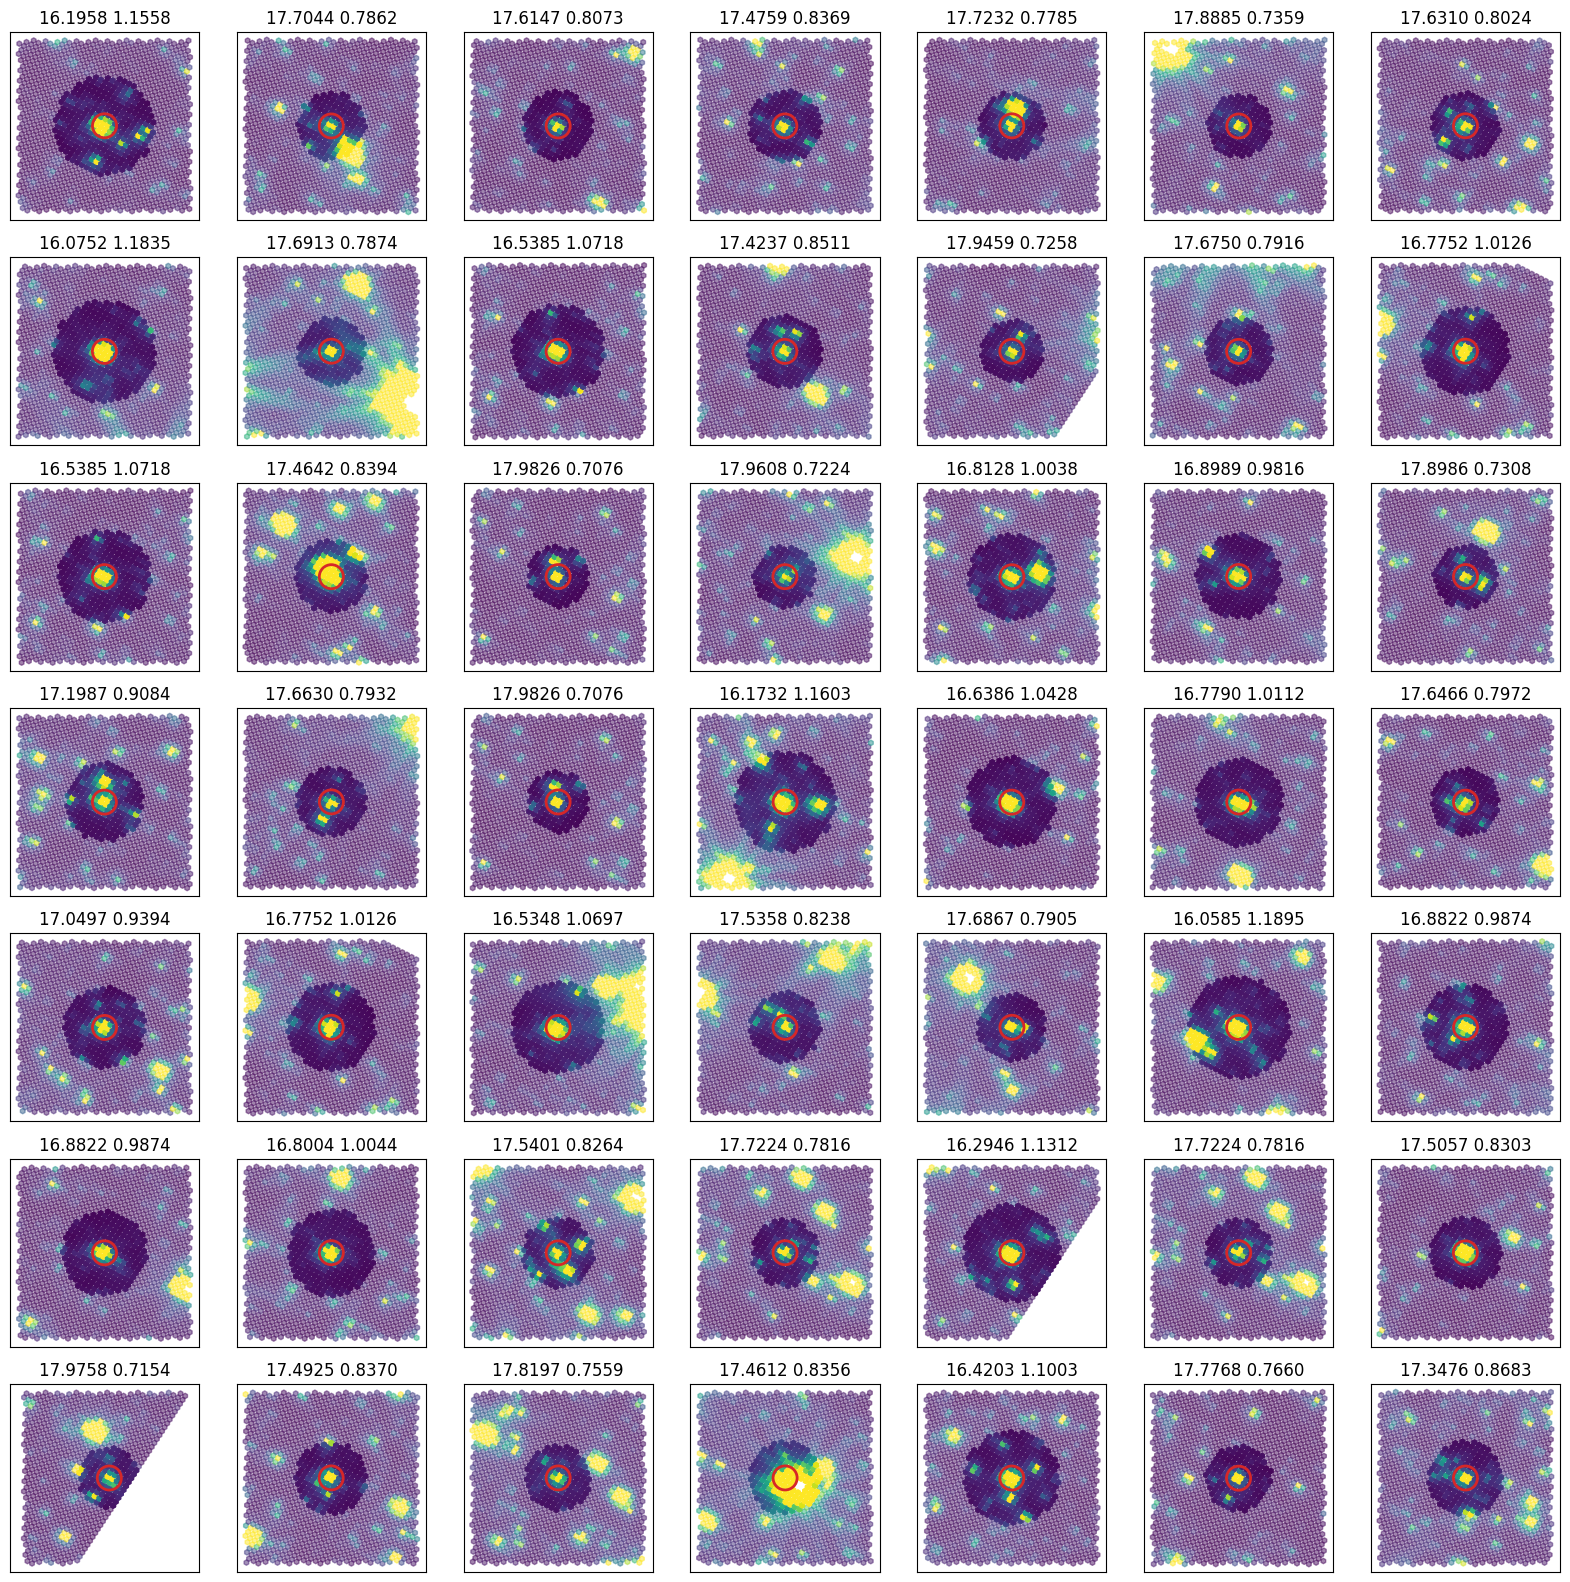

In [27]:
# we plot the source mask

flux_masked = mac.r.astype(bool).multiply(mac.flux[0]).tocsr()
source_mask_dx = mac.source_mask.multiply(mac.dra).tocsr()
source_mask_dy = mac.source_mask.multiply(mac.ddec).tocsr()
source_mask_flux = mac.source_mask.multiply(mac.flux[0]).tocsr()

fig, ax = plt.subplots(7, 7, figsize=(20,20))

for i, k in enumerate(examples):
    ax.ravel()[i].scatter(mac.dra[k].data*3600, 
                          mac.ddec[k].data*3600, 
                          s=15, marker="h", 
                          c=flux_masked[k].data, 
                          alpha=0.5,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(source_mask_dx[k].data*3600, 
                          source_mask_dy[k].data*3600, 
                          s=15, marker="h", 
                          c=source_mask_flux[k].data, 
                          alpha=1,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(0, 0, s=300, edgecolor="tab:red", marker="o", facecolor="none", lw=2)
    ax.ravel()[i].axis('equal')
    ax.ravel()[i].set_xticks([])
    ax.ravel()[i].set_yticks([])
    ax.ravel()[i].set_title(f"{mac.sources.F146.values[k]:0.4f} {mac.radius[k]:0.4f}")
plt.show()

`RomanMachine` computes a `source_mask`, which has shape `[nsources, npixels]`, with pixels that belong to a source. And also an `uncontaminated_source_mask`, with the same shape, but only with pixels that have a contribution from one source (down to `mac.contaminant_flux_limit`)

In [28]:
mac.source_mask, mac.uncontaminated_source_mask

(<Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 229837 stored elements and shape (3258, 262144)>,
 <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 93447 stored elements and shape (3258, 262144)>)

We can visualize the source mask and uncontaminated pixel mask to see if we have enough data points to build the PRF model

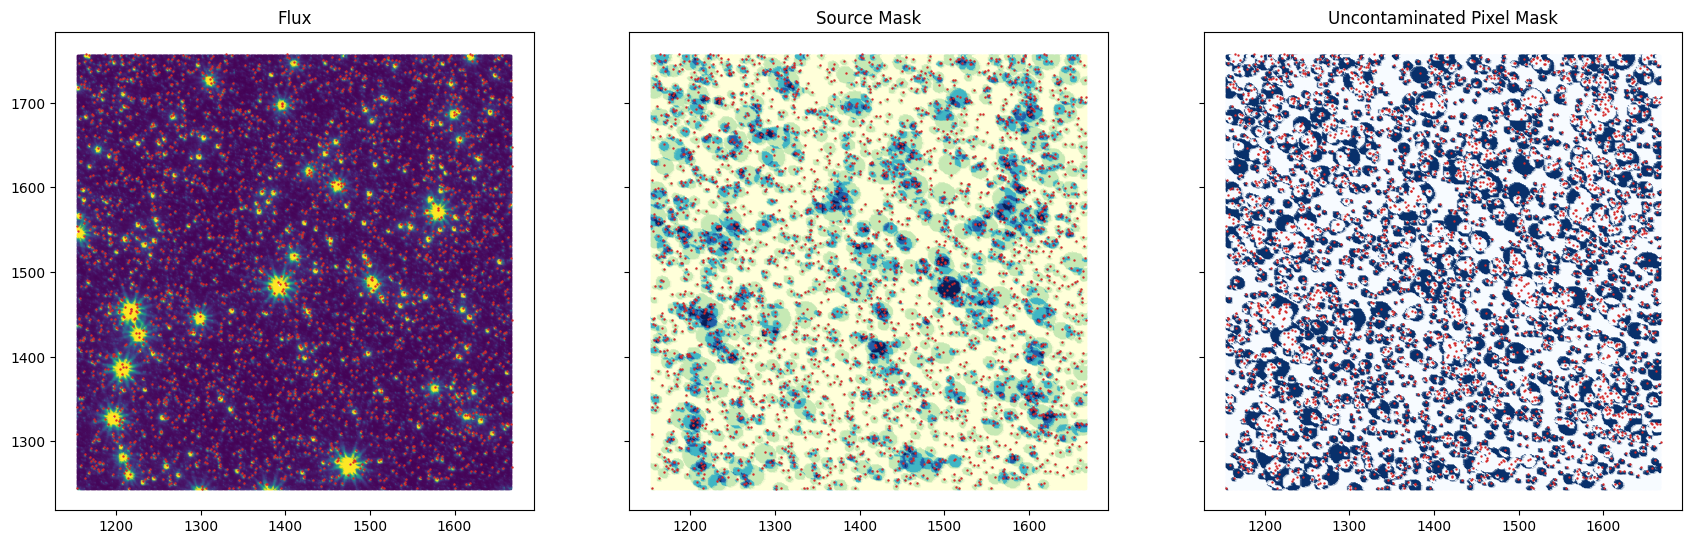

In [29]:
# mac._update_source_mask(frame_index=mac.ref_frame)
ROW, COL = mac.pixel_coordinates(mac.ref_frame)

fig, ax = plt.subplots(1, 3, figsize=(21, 10), sharex=True, sharey=True)

ax[0].set_title("Flux")
ax[0].scatter(
    mac.column[mac.ref_frame],
    mac.row[mac.ref_frame],
    c=mac.flux[mac.ref_frame], 
    vmin=10, 
    vmax=500,
    s=1,
    marker="s",
)
ax[0].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[1].set_title("Source Mask")
ax[1].scatter(
    mac.column[mac.ref_frame],
    mac.row[mac.ref_frame],
    c=np.array(mac.source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=4,
    alpha=1,
    cmap="YlGnBu",
    s=1,
    marker="s",
)
ax[1].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[2].set_title("Uncontaminated Pixel Mask")
ax[2].scatter(
    mac.column[mac.ref_frame],
    mac.row[mac.ref_frame],
    c=np.array(mac.uncontaminated_source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=1,
    alpha=1,
    cmap="Blues",
    s=1,
    marker="s",
)
ax[2].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[0].set_aspect("equal", adjustable="box")
ax[1].set_aspect("equal", adjustable="box")
ax[2].set_aspect("equal", adjustable="box")

plt.show()

Now we can build a PRF model using the uncontaminated pixels. We define a few model parameters like the minimun `rmin` and maximum `rmax` radius to fit the model in polar coordinates (these are related to the pixel scale), the radius at which the model start to be dependent on the polar angle (`cut_r`), and the number of knots for the radius and angle spline components. 
We also control where the PSF meets the background level with `flux_cut_off` parameter.

Aditionally, we bin the data with 300 bins in each axis, this helps removing pixel outliers that remain due to contamination. 

Creating delta arrays: 100%|██████████████████████████████████████████████████████████████| 3258/3258 [00:04<00:00, 729.47it/s]


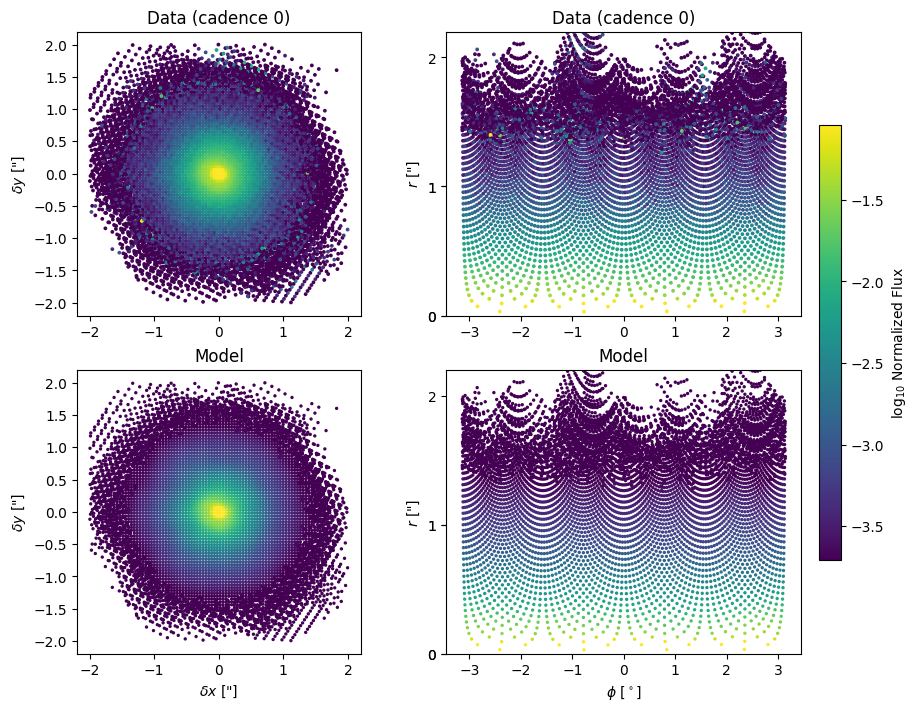

In [32]:
mac.rmin = 0.02
mac.rmax = 1.0
mac.cut_r = 0.2
mac.n_r_knots = 9
mac.n_phi_knots = 15
# we are fitting one single frame
psf_tdx = 0

mac.build_shape_model(
    plot=True,
    flux_cut_off=0.01,
    frame_index=psf_tdx,
    bin_data=300,
)
plt.show()

The top rows shows the data, each point is a pixel relative location to its source and the color is the normalized flux value.
The bottom row is the model we fit.
Both are show in cartesian (left) and polar (right) coordinates.

Let's make an overampled version (high resolution) version of the PRF model

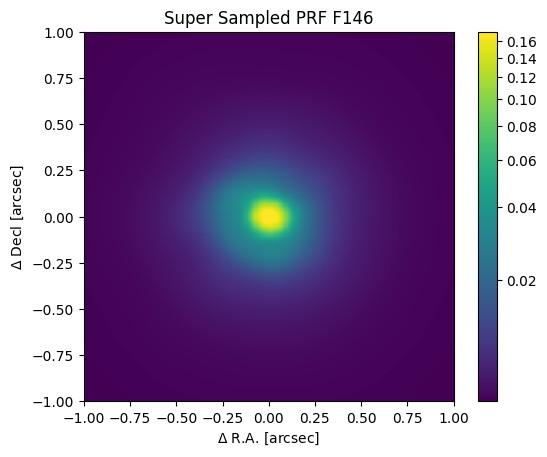

In [52]:
mac.plot_prf_model(hires=True);

We can save the PRF model we built:

In [54]:
output = f"./roman_WFI_rampfitted_{FILTER}_{FIELD}_SCA{SCA:02}_shape_model_cad0_center_v3.fits"
mac.save_shape_model(output=output, save=True)

We can see whats in the outputfile:

The FITS file has relevant keywords to build the components of a design matrix using any pixel row and column grid, as well as metadata that refers to the field, detector, filter, etc.  

In [59]:
prf_model = fits.open(output)
prf_model[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                  182 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'psf_w   '                                                            
TFORM1  = 'D       '                                                            
OBJECT  = 'PRF shape'          / PRF shape parameters                           
DATATYPE= 'SimImage'           / Type of data used to fit shape model           
ORIGIN  = 'PSFmachine.RomanM

The data store are the weights that the design matrix is dotted to obtain the unscaled image model.

In [56]:
prf_model[1].data

FITS_rec([( -8.30488172,), ( -8.21172055,), ( -8.22169964,),
          ( -8.16472151,), ( -8.2048815 ,), ( -8.29417724,),
          ( -8.1893121 ,), ( -8.22337383,), ( -8.11635359,),
          ( -8.311143  ,), ( -8.16628165,), ( -8.19452709,),
          ( -8.22057466,), ( -8.16245786,), ( -8.18284975,),
          ( -8.20898049,), ( -8.26855314,), ( -8.29943403,),
          ( -8.29837984,), ( -8.31957461,), ( -8.24910167,),
          ( -8.29470798,), ( -8.28002132,), ( -8.3408838 ,),
          ( -8.23421757,), ( -8.2929836 ,), ( -8.31391925,),
          ( -8.31063839,), ( -8.35822279,), ( -8.34587898,),
          ( -8.47365495,), ( -8.49622707,), ( -8.39617198,),
          ( -8.40835883,), ( -8.32357916,), ( -8.35420063,),
          ( -8.37795345,), ( -8.41847664,), ( -8.36525506,),
          ( -8.50084806,), ( -8.44604148,), ( -8.36473204,),
          ( -8.38727098,), ( -8.29940837,), ( -8.37880666,),
          ( -9.06717427,), ( -9.08257655,), ( -9.14939508,),
          ( -9.06112091,

We could use this PRF model to fit the photometry in this frame, but due to the large number of sources, the design matrix becomes singular, and least square fitting won't work.

In [60]:
# this shows that fitting the model leads to a singular matrix and nan values in the resulting photometry.
mac.quiet = True
mac.fit_model()
# mac.ws has the flux values for each source, which in this case are all nan
print(np.nansum(mac.ws))

0.0


To solve this, we will have to load a smaller cutout (e.g. 32 x 32 pixels), to simplify the problem, and load the precomputed PRF model for evaluation. m